In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import glob
import torch
from torch_geometric.utils.convert import from_networkx
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU
from torch_geometric.nn import GCNConv, GINConv, GATv2Conv
import random
import math 
from sklearn.manifold import TSNE
from IPython.display import clear_output
import matplotlib.colors 
import time 
from sklearn.model_selection import KFold

seed = 826
torch.manual_seed(seed)
np.random.seed(seed)

In [2]:
#Load in the reactome networks as a dictionary of dataFrames
#reactomeFilesFile = 'allDevReactomePathsCom.txt'
reactomeFilesFile = 'allDevReactomePaths.txt'
#We will not add pathways with fewer nodes than this
MIN_NETWORK_SIZE_THRESHOLD = 4
allPathDFs = dict()
allPathNets = dict()
locList = ["cytosol","extracellular","membrane","nucleus","secretory-pathway","mitochondrion"]
locDict = {"cytosol":0,"extracellular":1,"membrane":2,"mitochondrion":5,"nucleus":3,"secretory-pathway":4}
colNames = ["Interactor1", "Edge Type", "Interactor2", "Location"]
for line in open(reactomeFilesFile, "r"):
    pName = line.strip().split("/")[-1]
    pathDF = pd.read_csv(line.strip(), sep="\t", header=None, names=colNames, dtype=str)
    pathDF["loc_feat"] = pathDF['Location'].map(locDict)
    if len(pathDF) >= MIN_NETWORK_SIZE_THRESHOLD:
        allPathDFs[pName] = pathDF
        allPathNets[pName] = nx.from_pandas_edgelist(pathDF, source='Interactor1', 
                                                     target='Interactor2', edge_attr= ['Edge Type','Location','loc_feat'])
print("Loaded in %d pathways" %len(allPathDFs)) 

Loaded in 35 pathways


In [3]:
#Load in all comPPI Data as a dataframe too
#comPPIFile = '../../scripts/exploratoryScripts/comPPINodes.tsv'
comPPIFile = '../../data/uniprotKeywords/mergedKeyWords_5.tsv'
comPPIDF = pd.read_csv(comPPIFile, sep="\t", index_col="uniprot")
comPPIDF

comPPIDict = comPPIDF.to_dict('index')

#Make a uniform attribute row for misses
uniform = dict()
for feat in comPPIDF.columns:
    uniform[feat] = 1.0/(len(comPPIDF.columns))

In [4]:
#Now merge it to the created networks
for p in allPathNets:
    net = allPathNets[p]
    #Give missing data a uniform distribution
    for k in net.nodes():
        if k not in comPPIDict:
            comPPIDict[k] = uniform
    nx.set_node_attributes(net, comPPIDict)

#Look at one of the networks
testP = allPathNets['R-HSA-375165.txt']
print(f'graph has {testP.number_of_nodes()} nodes and {testP.number_of_edges()} undirected edges')
i=1
print("\n3 Nodes:")
for k,v in testP.nodes(data=True):
    print(k,v)
    i+=1
    if i>3: break

print("\n3 Edges:")
for k1,k2,v in testP.edges(data=True):
    print(k1,k2,v)
    i+=1
    if i>6: break
        

graph has 22 nodes and 108 undirected edges

3 Nodes:
CHEBI:15422 {'cytosol_comPPI': 0.08333333333333333, 'extracellular_comPPI': 0.08333333333333333, 'membrane_comPPI': 0.08333333333333333, 'mitochondrion_comPPI': 0.08333333333333333, 'nucleus_comPPI': 0.08333333333333333, 'secretory-pathway_comPPI': 0.08333333333333333, 'pca0_compartments': 0.08333333333333333, 'pca1_compartments': 0.08333333333333333, 'pca2_compartments': 0.08333333333333333, 'pca3_compartments': 0.08333333333333333, 'pca4_compartments': 0.08333333333333333, 'pca5_compartments': 0.08333333333333333}
FGFR1 {'cytosol_comPPI': 0.0117647058823529, 'extracellular_comPPI': 0.0117647058823529, 'membrane_comPPI': 0.0117647058823529, 'mitochondrion_comPPI': 0.0117647058823529, 'nucleus_comPPI': 0.9411764705882352, 'secretory-pathway_comPPI': 0.0117647058823529, 'pca0_compartments': 1.2628936083333695, 'pca1_compartments': 3.963090634206856, 'pca2_compartments': 2.905609231608951, 'pca3_compartments': 3.656552757956125, 'pca4

In [5]:
#So I'll want a graph object for each pathway as a networkx graph
dataList = []
nameMap = dict()
for p in allPathNets:
    nameMap[p] = len(dataList)
    graphData = from_networkx(allPathNets[p], group_node_attrs=all, group_edge_attrs=['loc_feat'])
    graphData['y'] = graphData.edge_attr.squeeze(1)
    graphData.num_classes = len(locList)
    dataList.append(graphData)

### Train-Test Split With Mini-Batching

In [6]:

nFolds = 5
kf = KFold(n_splits = nFolds)
np.random.shuffle(dataList)

train_sets = []
test_sets = []
train_loaders = []
test_loaders = []

for tr_ind, te_ind in kf.split(dataList):
    trains = []
    tests = []
    for ind in tr_ind:
        trains.append(dataList[ind])
    for ind in te_ind:
        tests.append(dataList[ind])
    
    train_sets.append(trains)
    test_sets.append(tests)
    
    train_loader = DataLoader(trains, batch_size=64, shuffle=False)
    test_loader = DataLoader(tests, batch_size=64, shuffle=False)
    
    train_loaders.append(train_loader)
    test_loaders.append(test_loader)

###  Representation

We have three options for representing the pathways

1. Make bipartite graphs (similar to how we're already doing things). We can use [heterogeneous graphs](https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html).
2. Invert the graph's nodes and edges to make a hypergraph, then flatten that representation with pairwise edges. This approach wouldn't 'waste' any computation predicting nodes, and we could use it to represent many of the actual hyperedges in biological pathways (though generally not in constructed graphs). In terms of how a graph convolution behaves, I think a fully connected set of nodes would act identical to a convolution or message passing on a hyperedge. 
3. Keep the graph as it originally is, do a node2vec or other embedding, and then just use those features to predict the localizations. But it node2vec isn't really made to work on multiple graphs. What if we sought to instead learn a real embedding of the nodes in the graph according to their localization in the pathway. Then classified edges on their actual position. As in we have a system for saying that a node's embedding needs to be representative of it's actual localization. So that in that embedding we could literally divide the space by localization. Like node2vec but simultaniously it also tries to minimize nodes of the same localization being close to eachother. 
    We could set up edge weights to represent localizations real hard, different ones very far away? not really
    This really isn't that different than just getting localizations out at the end. 
4. First make a cnn representation, then make a network that can take in each pair of nodes and make an edge prediction
    

In [7]:
class LinearNN(torch.nn.Module):
    def __init__(self, dataset):
        super(LinearNN, self).__init__()
        torch.manual_seed(seed)
        self.l1 = Linear(dataset.num_features*2, 24)
        self.l2 = Linear(24, 18)
        self.l3 = Linear(18, 12)
        self.classifier = Linear(12, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        #Take the node embeddings and concat nodes for each edge
        e = torch.cat((x[edge_index[0]], x[edge_index[1]]), dim=1)
        
        h = self.l1(e)
        h = h.tanh()
        h = self.l2(h)
        h = h.tanh()
        h = self.l3(h)
        h = h.tanh()  
        out = self.classifier(h)

        return out, h

In [8]:
# Option 4

# GCN class from tutorial notebook 1
# Modified the seed, the constructor, from Tony
class SimpleGCN(torch.nn.Module):
    def __init__(self, dataset):
        super(SimpleGCN, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = GCNConv(dataset.num_features, 18)
        self.conv2 = GCNConv(18, 24)
        self.conv3 = GCNConv(24, dataset.num_features*2)
        self.lin1 = Linear(dataset.num_features*2, 24)
        self.lin2 = Linear(24, 18)
        self.lin3 = Linear(18, 12)
        self.classifier = Linear(12*2, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  
        h = self.lin1(h) 
        h = h.tanh()
        h = self.lin2(h) 
        h = h.tanh() 
        h = self.lin3(h) 
        h = h.tanh()# Final GNN embedding space.
        
        #Take the node embeddings and concat nodes for each edge
        e = torch.cat((h[edge_index[0]], h[edge_index[1]]), dim=1)
        
        # Apply a final (linear) classifier.
        out = self.classifier(e)

        return out, e

In [9]:
class GATCONV(torch.nn.Module):
    """
    A graph attention network with 4 graph layers and 2 linear layers.
    Uses v2 of graph attention that provides dynamic instead of static attention.
    The graph layer dimension and number of attention heads can be specified.
    """
    def __init__(self, dataset, dim=8, num_heads=4):
        super(GATCONV, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = GATv2Conv(in_channels=dataset.num_features, out_channels=dim, heads=num_heads)
        # The graph attention layer provides a re-weighted version of the output node representation for every
        # attention heads in the default setting, which is why we multiply by num_heads
        self.conv2 = GATv2Conv(in_channels=dim * num_heads, out_channels=dim, heads=num_heads)
        self.conv3 = GATv2Conv(in_channels=dim * num_heads, out_channels=dim, heads=num_heads)
        self.conv4 = GATv2Conv(in_channels=dim * num_heads, out_channels=dim, heads=num_heads)
        self.lin1 = Linear(dim * num_heads, dim)
        self.lin2 = Linear(dim*2, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()
        h = self.conv4(h, edge_index).relu()
        h = self.lin1(h).relu()
        h = F.dropout(h, p=0.5, training=self.training)
        
        #Take the node embeddings and concat nodes for each edge
        e = torch.cat((h[edge_index[0]], h[edge_index[1]]), dim=1)
        
        out = self.lin2(e)

        return out, e

In [10]:

class DeepGCN(torch.nn.Module):
    """
    A graph convolutional network with 5 graph layers and 1 linear layer.
    The dimension of the hidden layers is customizable and decreases
    at the higher layers.
    """
    def __init__(self, dataset, hidden_channels=30):
        super(DeepGCN, self).__init__()
        torch.manual_seed(seed)
        # Automatically determine how much to shrink the dimensionality of the hidden layers
        hidden_channels_2 = max(1, math.floor(hidden_channels / 2))
        hidden_channels_3 = max(1, math.floor(hidden_channels_2 / 2))

        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels_2)
        self.conv4 = GCNConv(hidden_channels_2, hidden_channels_2)
        self.conv5 = GCNConv(hidden_channels_2, dataset.num_features*2)
        self.lin1 = Linear(dataset.num_features*2, 24)
        self.lin2 = Linear(24, 18)
        self.lin3 = Linear(18, 12)
        self.classifier = Linear(12*2, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()
        h = self.conv4(h, edge_index)
        h = h.tanh()
        h = self.conv5(h, edge_index)
        h = h.tanh()          
        h = self.lin1(h) 
        h = h.tanh()
        h = self.lin2(h) 
        h = h.tanh() 
        h = self.lin3(h) 
        h = h.tanh()# Final GNN embedding space.# Final GNN embedding space.

        #Take the node embeddings and concat nodes for each edge
        e = torch.cat((h[edge_index[0]], h[edge_index[1]]), dim=1)
        
        # Apply a final (linear) classifier.
        out = self.classifier(e)

        return out, e

In [11]:
# See https://github.com/pyg-team/pytorch_geometric/blob/master/examples/mutag_gin.py
##### Use this version with cross entropy loss instead of the GIN class above
class GIN2(torch.nn.Module):
    def __init__(self, dataset, dim=16):
        super(GIN2, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = GINConv(Sequential(Linear(dataset.num_features, dim), BatchNorm1d(dim), ReLU(),
                                        Linear(dim, dim), ReLU()))
        self.conv2 = GINConv(Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                                        Linear(dim, dim), ReLU()))
        self.conv3 = GINConv(Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                                        Linear(dim, dim), ReLU()))
        self.conv4 = GINConv(Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                                        Linear(dim, dim), ReLU()))
        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim*2, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index)
        h = self.conv2(h, edge_index)
        h = self.conv3(h, edge_index)
        h = self.conv4(h, edge_index)
        h = self.lin1(h).relu()
        h = F.dropout(h, p=0.5, training=self.training)
        
        #Take the node embeddings and concat nodes for each edge
        e = torch.cat((h[edge_index[0]], h[edge_index[1]]), dim=1)
        
        out = self.lin2(e)

        return out, e

In [12]:
# Function from tutorial notebook 2
# Modified argument name, added legend (hard-coded for inviable class label), add PCA init and seed, perplexity
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html gives the default perplexity of 30.0
def visualize(embedding, color, tsne_perplexity=30.0):
    z = TSNE(n_components=2, init='pca', random_state=seed, perplexity=tsne_perplexity).fit_transform(embedding.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    # Add legend using https://stackoverflow.com/a/58516451
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2", norm=matplotlib.colors.Normalize(vmin=0,vmax=5))
    plt.legend(handles=scatter.legend_elements()[0], labels=locList)
    plt.show()

#This will break if there's not the expected number of lines already existing
def livePlot(ax, list_of_lists, labels):
    clear_output(wait=True)
    for i in range(len(list_of_lists)):
        y_data = list_of_lists[i]
        ax.plot(range(len(y_data)),y_data,label=labels[i])
    leg = plt.legend(loc='best', ncol=2)
    plt.show()

    

In [13]:
def train(loader, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    for data in loader:  # Iterate in batches over the training dataset.
         out,e = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.


def test(loader, model):
     model.eval()

     correct = 0
     total = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out,e = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
         total += len(data.y)
     return correct / total  # Derive ratio of correct predictions.

def getEmbedding(loader, model):
    model.eval()
    embeddingAll = None
    yAll = None
    for data in loader:  # Iterate in batches over the training/test dataset.
         out,e = model(data.x, data.edge_index, data.batch)
         if (embeddingAll == None):
            embeddingAll = e
            yAll = data.y
         else:
            embeddingAll = torch.cat((embeddingAll,e), dim=0)
            yAll = torch.cat((yAll,data.y), dim=0)
    return embeddingAll, yAll

def evalModel(model, train_loader, test_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
    criterion = torch.nn.CrossEntropyLoss()

    train_acc_list = []
    test_acc_list = []
    previous_time = time.time()
    for epoch in range(1, 10001):
        train(train_loader, model, optimizer, criterion)
        train_acc = test(train_loader, model)
        test_acc = test(test_loader, model)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        curr_time = time.time()
        if curr_time - previous_time > 2:
            fig,ax = plt.subplots(1,1)
            livePlot(ax, [train_acc_list, test_acc_list],["training acc","testing acc"])
            print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
            previous_time = time.time()
    fig,ax = plt.subplots(1,1)
    livePlot(ax, [train_acc_list, test_acc_list],["training acc","testing acc"])
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

In [14]:
def evalModelCV(models, train_loaders, test_loaders):
    optimizers = []
    criteria = []
    for i in range(len(train_loaders)):
        optimizers.append(torch.optim.Adam(models[i].parameters(), lr=0.00005))
        criteria.append(torch.nn.CrossEntropyLoss())

    train_acc_list = []
    test_acc_list = []
    previous_time = time.time()
    
    for epoch in range(1, 5001):  
        train_acc = 0.0
        test_acc = 0.0
        for i in range(len(train_loaders)):
            train(train_loaders[i], models[i], optimizers[i], criteria[i])
            train_acc += test(train_loaders[i], models[i])
            test_acc += test(test_loaders[i], models[i])
        train_acc_list.append(train_acc/len(train_loaders))
        test_acc_list.append(test_acc/len(train_loaders))
            
        curr_time = time.time()
        if curr_time - previous_time > 2:
            fig,ax = plt.subplots(1,1)
            livePlot(ax, [train_acc_list, test_acc_list],["training acc","testing acc"])
            print(f'Epoch: {epoch:03d}, Train Acc: {train_acc_list[-1]:.4f}, Test Acc: {test_acc_list[-1]:.4f}')
            previous_time = time.time()
    fig,ax = plt.subplots(1,1)
    livePlot(ax, [train_acc_list, test_acc_list],["training acc","testing acc"])
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc_list[-1]:.4f}, Test Acc: {test_acc_list[-1]:.4f}')

### CV Models (Just plots the average for now)

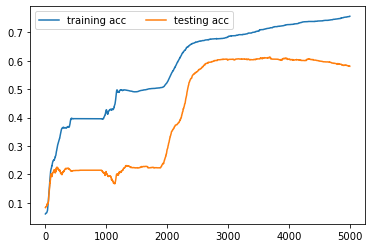

Epoch: 5000, Train Acc: 0.7565, Test Acc: 0.5806


In [15]:
models = []
for i in range(len(train_loaders)):
    #There was some debate online about if deepcopy works, so let's just make new ones
    models.append(LinearNN(dataList[0]))
evalModelCV(models, train_loaders, test_loaders)

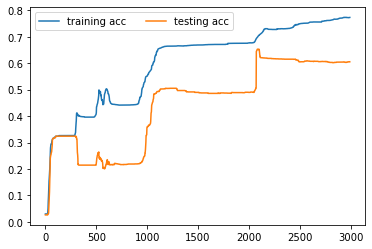

Epoch: 2991, Train Acc: 0.7735, Test Acc: 0.6056


KeyboardInterrupt: 

In [16]:
models = []
for i in range(len(train_loaders)):
    #There was some debate online about if deepcopy works, so let's just make new ones
    models.append(SimpleGCN(dataList[0]))
evalModelCV(models, train_loaders, test_loaders)

In [ ]:
models = []
for i in range(len(train_loaders)):
    #There was some debate online about if deepcopy works, so let's just make new ones
    models.append(DeepGCN(dataList[0]))
evalModelCV(models, train_loaders, test_loaders)

In [ ]:
models = []
for i in range(len(train_loaders)):
    #There was some debate online about if deepcopy works, so let's just make new ones
    models.append(GATCONV(dataList[0]))
evalModelCV(models, train_loaders, test_loaders)

In [17]:
models = []
for i in range(len(train_loaders)):
    #There was some debate online about if deepcopy works, so let's just make new ones
    models.append(GIN2(dataList[0]))
evalModelCV(models, train_loaders, test_loaders)

KeyboardInterrupt: 

### Single Fold Models (old)

In [ ]:
em, yAll = getEmbedding(test_loaders[0], models[0])
visualize(em, yAll, tsne_perplexity=30.0)

In [ ]:
em2, yAll2 = getEmbedding(train_loaders[0], models[0])
visualize(em2, yAll2, tsne_perplexity=30.0)

In [ ]:
em3 = torch.cat((em,em2), dim=0)
yAll3 = torch.cat((yAll,yAll2), dim=0)
visualize(em3, yAll3, tsne_perplexity=30.0)